# Goal: What features correlate with higher app ratings?

https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps


Using 10k app dataset from Kaggle, giving 7197 apps to analyze. Dataset gives App price, ratings, new version ratings, genre, bytes, etc.

In this project, I find the importance of considering non-linear relationships and visual patterns, rather than relying solely on correlation coefficients, when evaluating app success.



## 1. Data Downloading/Overview

In [1]:
import kagglehub

path = kagglehub.dataset_download("ramamet4/app-store-apple-data-set-10k-apps")

print("Path to dataset files:", path)

100%|██████████| 5.63M/5.63M [00:00<00:00, 26.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ramamet4/app-store-apple-data-set-10k-apps/versions/7


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
plt.style.use('ggplot')

#grab file
csv_path = os.path.join(path, "AppleStore.csv")

#get data from file name
df = pd.read_csv(csv_path)

In [120]:
#Visualize data
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7197 non-null   int64  
 1   id                7197 non-null   int64  
 2   track_name        7197 non-null   object 
 3   size_bytes        7197 non-null   int64  
 4   currency          7197 non-null   object 
 5   price             7197 non-null   float64
 6   rating_count_tot  7197 non-null   int64  
 7   rating_count_ver  7197 non-null   int64  
 8   user_rating       7197 non-null   float64
 9   user_rating_ver   7197 non-null   float64
 10  ver               7197 non-null   object 
 11  cont_rating       7197 non-null   object 
 12  prime_genre       7197 non-null   object 
 13  sup_devices.num   7197 non-null   int64  
 14  ipadSc_urls.num   7197 non-null   int64  
 15  lang.num          7197 non-null   int64  
 16  vpp_lic           7197 non-null   int64  


,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


## 2. Data Cleaning

In [121]:
#checking for duplicate apps
app_counts = df['track_name'].value_counts()
duplicate_apps = app_counts[app_counts > 1]
duplicate_apps

,count
track_name,
VR Roller Coaster,2
Mannequin Challenge,2


In [122]:
#dropping duplicate apps
df.sort_values('user_rating', ascending=False, inplace=True)
df.drop_duplicates(subset='track_name', keep='first', inplace=True)

In [123]:
#checking if all currency is given in USD to see
#if column can be dropped
df['currency'].value_counts()

,count
currency,
USD,7195


In [124]:
# Checking for null data
for col in df.columns:
  pct_missing = np.mean(df[col].isnull())
  print("{} - {}%".format(col, pct_missing))

Unnamed: 0 - 0.0%
id - 0.0%
track_name - 0.0%
size_bytes - 0.0%
currency - 0.0%
price - 0.0%
rating_count_tot - 0.0%
rating_count_ver - 0.0%
user_rating - 0.0%
user_rating_ver - 0.0%
ver - 0.0%
cont_rating - 0.0%
prime_genre - 0.0%
sup_devices.num - 0.0%
ipadSc_urls.num - 0.0%
lang.num - 0.0%
vpp_lic - 0.0%


In [125]:
#Begin Cleaning Data
# removing version data as well to simplify analysis for this project
df = df.drop(['ver', 'vpp_lic', 'ipadSc_urls.num',
              'currency', 'Unnamed: 0', 'id',
              'track_name', 'rating_count_ver', 'user_rating_ver'], axis = 1)
df.columns

Index(['size_bytes', 'price', 'rating_count_tot', 'user_rating', 'cont_rating',
       'prime_genre', 'sup_devices.num', 'lang.num'],
      dtype='object')

In [126]:
#Renaming Columns For Better Understanding
df = df.rename(columns = {
                     'size_bytes': 'Bytes',
                     'price': 'Price',
                     'rating_count_tot': 'Total_Number_Rating',
                     'cont_rating': 'Age'})

In [127]:
#Assigning Binary Values To Price
df['Is_Paid'] = (df['Price']>0).astype(int)

#Converting age to integer
df['Age'] = df['Age'].str.replace('+', '')
df['Age'].head(5)

,Age
4470,4
5566,4
4240,9
1477,4
5484,12


In [128]:
#Uncomment for full look at data for visual analysis
#pd.set_option('display.max_rows', None)
#df.sort_values(by=['user_rating'], inplace=False, ascending=False)

Using visual analysis on my data, I hypothesize that:

- the version rating should be highly correlated with user rating
- the age should be negatively correlated with user rating
- paid apps will be positively correlated with user ratings
- amount of ratings will not be very correlated with user ratings

## 3. Distribution of Ratings

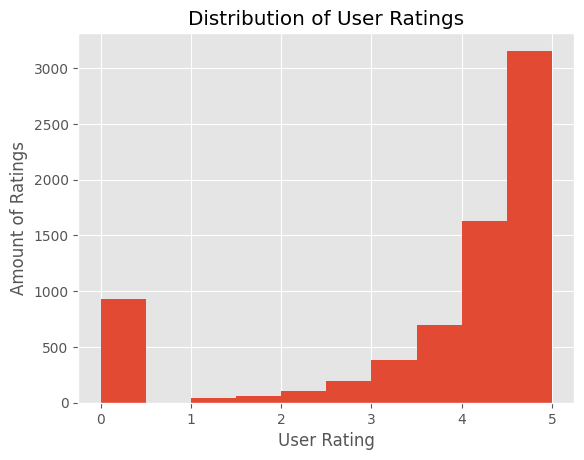

In [129]:
df['user_rating'].plot(kind = 'hist')
plt.ylabel('Amount of Ratings')
plt.xlabel('User Rating')
plt.title('Distribution of User Ratings')
plt.show()

There seems to be significantly more well-reviewed apps on the app store than those with low ratings(1-3 stars), with a slight increase in apps with extremely low ratings(0 stars). I assume this trend is due to the fact that people are more likely to leave a 0 star review for an app they disliked, rather than anything from 1-3 stars. People are also more likely to leave a review on an app they enjoyed a lot than an app they found mediocre.

## 4. Correlation Analysis

In [130]:
#Checking what categories dominate the app store
category_counts = df['prime_genre'].value_counts()
category_counts

,count
prime_genre,
Games,3860
Entertainment,535
Education,453
Photo & Video,349
Utilities,248
Health & Fitness,180
Productivity,178
Social Networking,167
Lifestyle,144


Looking at the saturation of apps, it seems that games and entertainment dominate the apps in the app store.

/tmp/ipython-input-2354299705.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = genre_ratings.values, y =genre_ratings.index, palette = 'Set2')


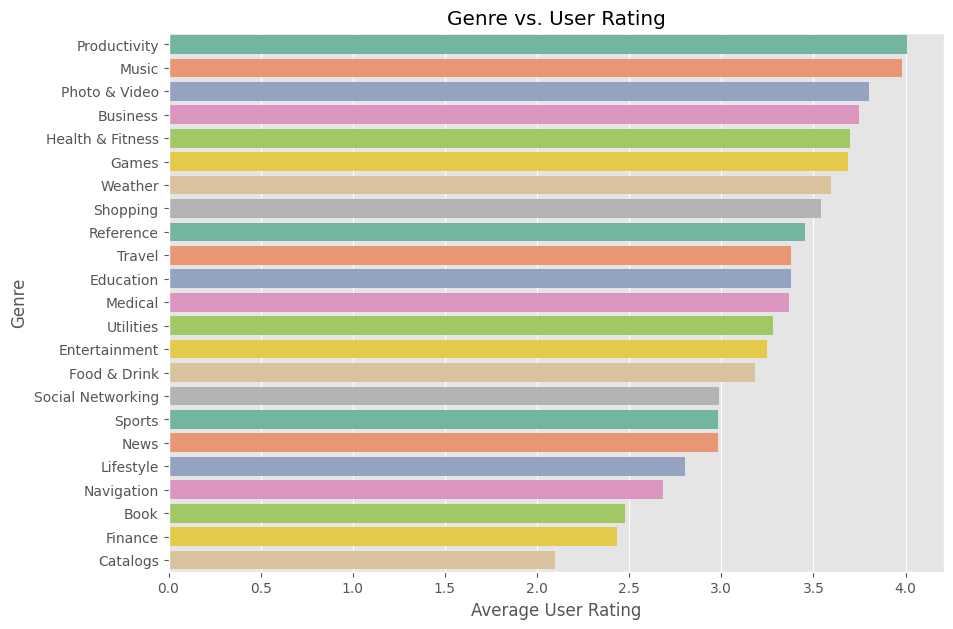

In [131]:
#Compare the genre to the overall user ratings of apps in bins
genre_ratings = df.groupby('prime_genre')['user_rating'].mean().sort_values(ascending = False)
plt.figure(figsize = (10,7))
sns.barplot(x = genre_ratings.values, y =genre_ratings.index, palette = 'Set2')
plt.title('Genre vs. User Rating')
plt.xlabel('Average User Rating')
plt.ylabel('Genre')
plt.show()

Despite Games dominating the app store, it seems they are not the genre with the highest average ratings. This is most likely a result of over saturation of the genre, resulting in both highly reviewed and very low reviewed games.

Productivity apps seem to be dominating in terms of average ratings, likely due to their focused functionality and niche audiences.


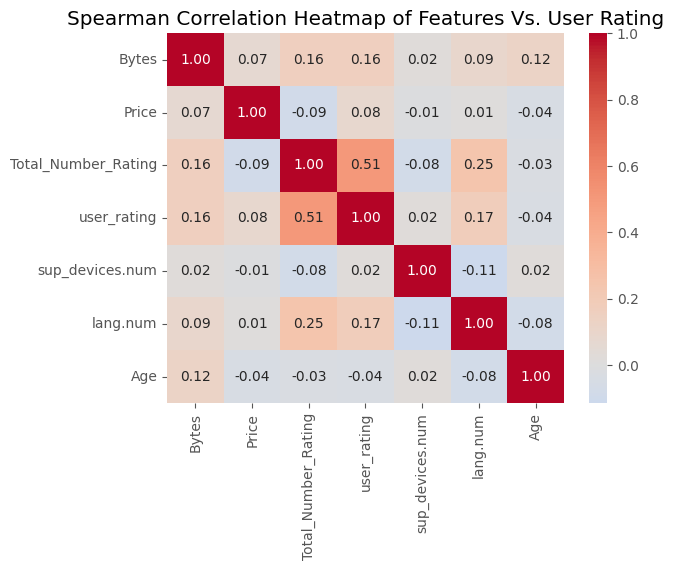

In [132]:
# Plot heatmap of features vs. overall user rating using spearman distribution
#I use spearman distribution since most of the data is skewed and requires
# a non-linear distribution analysis for more accurate correlation
numeric = ['Bytes', 'Price', 'Total_Number_Rating',
           'user_rating', 'sup_devices.num',
           'lang.num', 'Age']
corr_spearman = df[numeric].corr(method='spearman')
sns.heatmap(corr_spearman, annot=True, fmt = ".2f", cmap='coolwarm', center=0)
plt.title('Spearman Correlation Heatmap of Features Vs. User Rating')
plt.show()


This suggests:
- a small positive correlation (0.16) between the size of the app and the user rating, meaning bigger apps that offer more features slightly improve user satisfaction

- a very small positive correlation (0.08) between price and the user rating, meaning price does not strongly influence user ratings

- a positive correlation (0.51) between the total amount of ratings and the user ratings, meaning a more popular app sees a trend toward higher ratings. Will not elaborate on this section since it is clear that more popular apps would have better ratings.

- a very small positive correlation (0.02) between the amount of supporting devices and the user ratings, meaning the amount of devices supported by an app does not strongly influence the user ratings

- a moderate positive correlation (0.17) between the amount of languages supported by an app and the user rating, meaning apps that accomodate with localization tend to see slightly better reviews

- a small negative correlation (-.04) between age and user rating, meaning there is little significance in the effect of the target age group and an apps success.

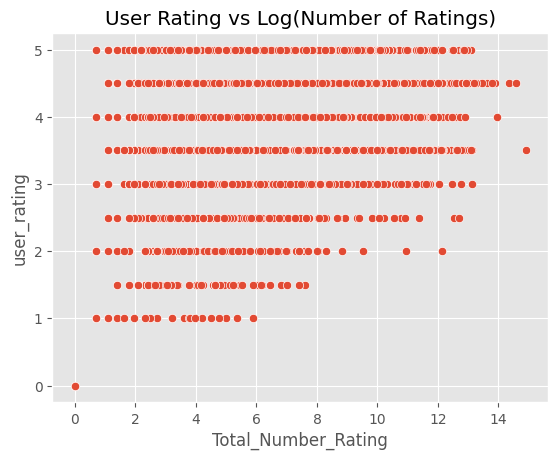

In [133]:
sns.scatterplot(x=np.log1p(df['Total_Number_Rating']), y=df['user_rating'])
plt.title("User Rating vs Log(Number of Ratings)")
plt.show()

By taking the log of the ratings, I can confirm visually a trend of apps that are more popular/reviewed tend to have higher ratings

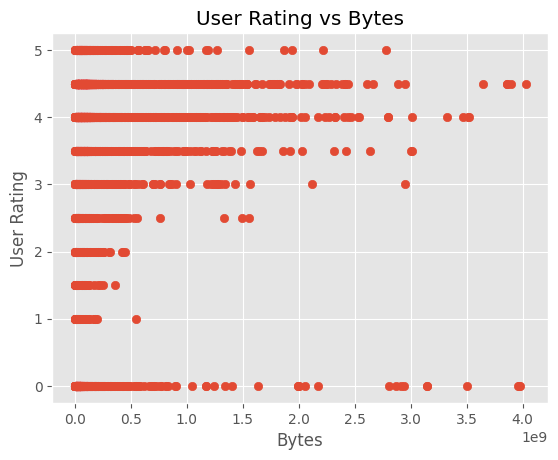

In [135]:
plt.scatter(x = df['Bytes'], y = df['user_rating'])
plt.title("User Rating vs Bytes")
plt.xlabel("Bytes")
plt.ylabel("User Rating")
plt.show()


/tmp/ipython-input-1443831753.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bytes_mean = df.groupby('Bytes')['user_rating'].mean().reset_index()


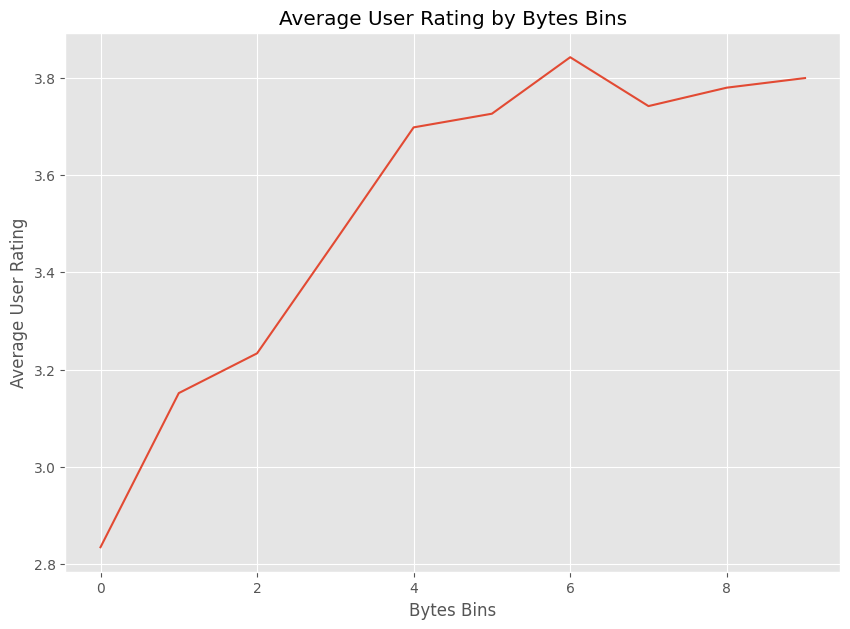

In [137]:
#average user rating per bytes bin graph
df['Bytes'] = pd.qcut(df['Bytes'], q = 10, duplicates = 'drop')
bytes_mean = df.groupby('Bytes')['user_rating'].mean().reset_index()

plt.figure(figsize = (10,7))
sns.lineplot(x = range(len(bytes_mean)), y = 'user_rating', data = bytes_mean)
plt.title('Average User Rating by Bytes Bins')
plt.xlabel('Bytes Bins')
plt.ylabel('Average User Rating')
plt.show()

In the above graph, I can see a trend where smaller, less complicated apps tend to see lower average user ratings. Up until a certain point, satisfaction increase with more bytes until the curve begins to flatten. This suggests that larger apps result in more user satisfaction up until a point where a larger app does not necessarily increase the user rating.

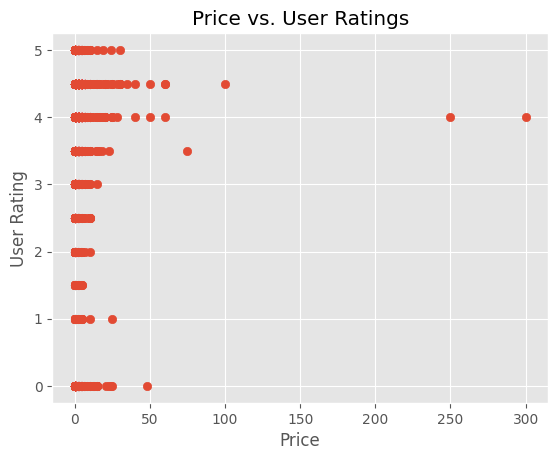

In [113]:
#Scatter plot of user ratings vs. price

plt.scatter(x = df['Price'], y= df['user_rating'])
plt.title('Price vs. User Ratings')
plt.xlabel('Price')
plt.ylabel('User Rating')
plt.show()


/tmp/ipython-input-3162313577.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_means = df.groupby('price_bin')['user_rating'].mean().reset_index()


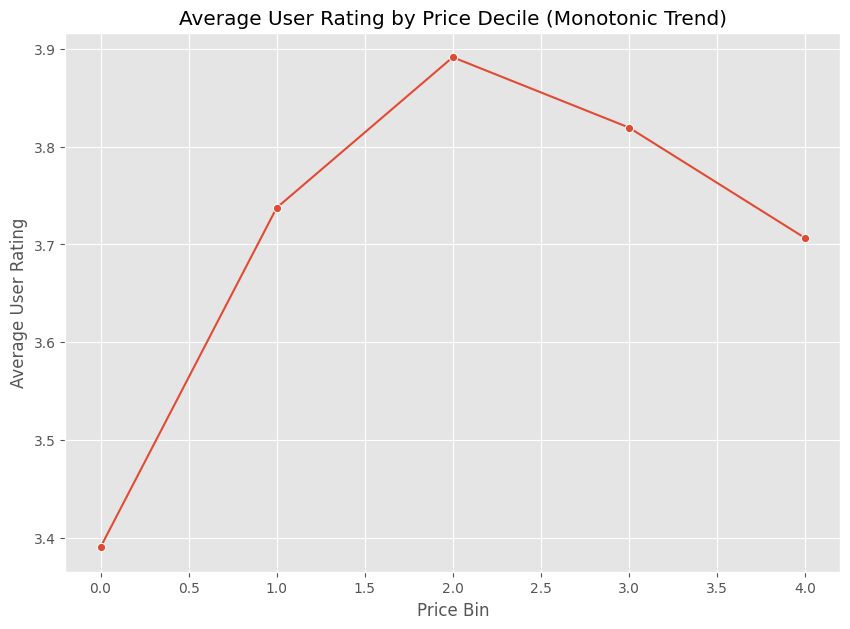

In [111]:
#average user rating per price bin
df['price_bin'] = pd.qcut(df['Price'], q=10, duplicates='drop')
price_means = df.groupby('price_bin')['user_rating'].mean().reset_index()

plt.figure(figsize=(10,7))
sns.lineplot(x=range(len(price_means)), y='user_rating', data=price_means, marker='o')
plt.title("Average User Rating by Price bin (Monotonic)")
plt.xlabel("Price Bin")
plt.ylabel("Average User Rating")
plt.show()

By using binned averages, I find a trend when comparing price to average user rating. I find that free-low cost apps tend to have lower-average ratings (3.4 - 3.6). But, as the cost of apps becomes moderate, the average ratings are at the highest (3.9). Then, as apps get more expensive, the average rating lowers again, but not to the extent of the low-cost apps(to around 3.7). This suggests that there is a median price to user satisfaction trend that can be found. Meaning, that low-cost apps can have less effort put into them, causing lower user satisfaction while median priced apps have enough added features/demand to keep users happy, without making them pay too much. Then, apps that are more expensive have a certain expectation for satisfaction, and users may feel that the high prices do not match the benefit of the app.

/tmp/ipython-input-1885335540.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='Is_Paid', y='user_rating', palette = "Set2",


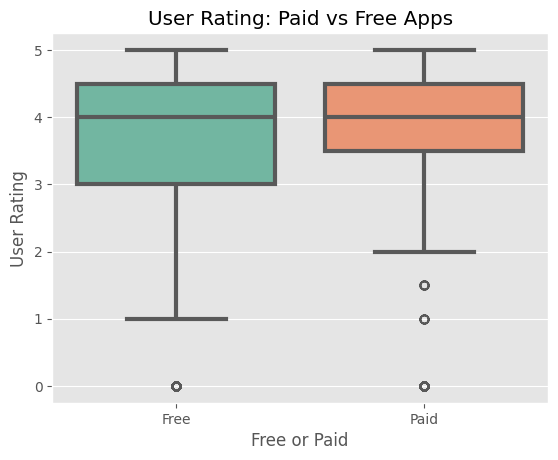

In [114]:
sns.boxplot(data = df, x='Is_Paid', y='user_rating', palette = "Set2",
            linewidth = 3)
plt.xticks([0,1], ['Free', 'Paid'])
plt.title('User Rating: Paid vs Free Apps')
plt.xlabel("Free or Paid")
plt.ylabel("User Rating")
plt.show()

While correlation between the price and user rating is low (0.08), the boxplot shows paid apps tend to have higher ratings, suggesting price may influence perceived quality. The earlier, small correlation, was likely as a result of the dominating amount of free apps on the store. This is most likely since paid apps have a more niche audience who is willing to pay for the service they are recieving, causing more user satisfaction. But, the differnece is subtle, causing it to be difficult to see by correlation.

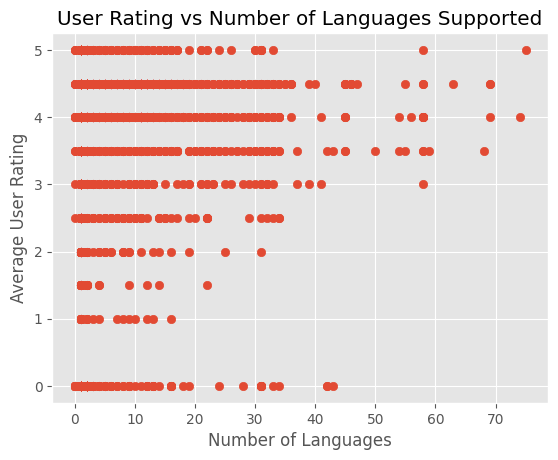

In [141]:
plt.scatter(x= df['lang.num'], y= df['user_rating'])
plt.title('User Rating vs Number of Languages Supported')
plt.xlabel('Number of Languages')
plt.ylabel('Average User Rating')
plt.show()

The scatter plot between average user rating and number of supported languages shows that most apps cluster around 0-20 languages (disregarding a few scattered for a rating of 0 stars), from 0-2 stars. But then, around 2.5 stars we see languages offered increase to around 35-40, going up to around 70. This could suggest that top apps tend to invest in multi-language support, making them more global and providing better user experience.

/tmp/ipython-input-1735409507.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lang_means = df.groupby('lang_bin')['user_rating'].mean().reset_index()


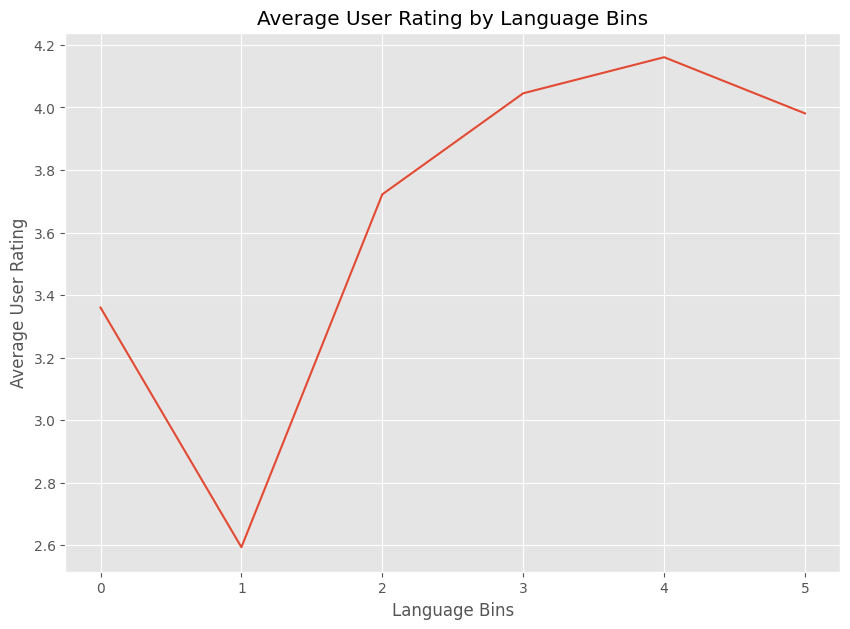

In [115]:
df['lang_bin'] = pd.qcut(df['lang.num'], q = 10, duplicates = 'drop')
lang_means = df.groupby('lang_bin')['user_rating'].mean().reset_index()

plt.figure(figsize = (10,7))
sns.lineplot(x = range(len(lang_means)), y = 'user_rating', data = lang_means)
plt.title('Average User Rating by Language Bins')
plt.xlabel('Language Bins')
plt.ylabel('Average User Rating')
plt.show()

The binned graph agrees with the scatter plot, showing that most apps with a small to moderate number of supported languages cluster around lower average ratings. There are a few outliers among apps with a large number of languages (30–40+) that have very low ratings, which may skew the mean in that range. Overall, there is a positive trend suggesting that apps supporting more languages tend to have higher average ratings, likely because these apps invest more in features and localization, improving user experience globally.

/tmp/ipython-input-1129351934.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_mean = df.groupby('age_bin')['user_rating'].mean().reset_index()


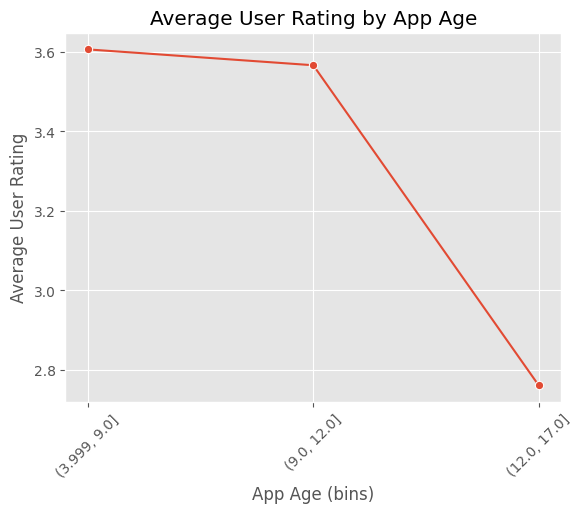

In [142]:
df['Age_num'] = df['Age'].astype(int)
df['age_bin'] = pd.qcut(df['Age_num'], q=10, duplicates='drop')
age_mean = df.groupby('age_bin')['user_rating'].mean().reset_index()

sns.lineplot(x=range(len(age_mean)), y='user_rating', data=age_mean, marker='o')
plt.xticks(range(len(age_mean)), [str(i) for i in age_mean['age_bin']], rotation=45)
plt.title("Average User Rating by Age")
plt.xlabel("Age Threshold")
plt.ylabel("Average User Rating")
plt.show()

/tmp/ipython-input-306673633.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df, x='Age', y='user_rating', palette = "Set2",


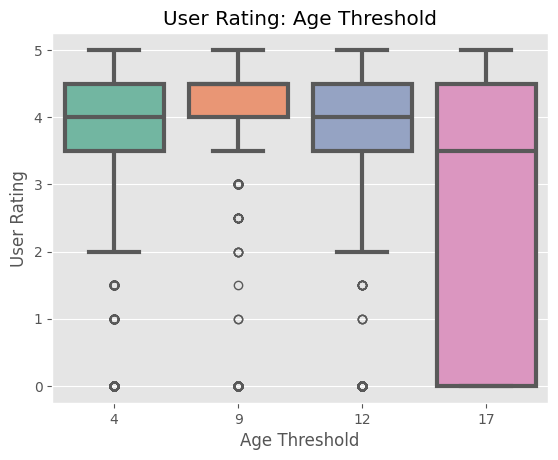

In [143]:
sns.boxplot(data = df, x='Age', y='user_rating', palette = "Set2",
            linewidth = 3)
plt.title('User Rating: Age Threshold')
plt.xlabel("Age Threshold")
plt.ylabel("User Rating")
plt.show()

While the correlation between user ratings and the minimum age requirement for an app is very low and negative, further analysis reveals a more nuanced pattern. Box plots and binned averages show that for most age categories, the age restriction has little impact on average ratings. However, apps targeted at older audiences tend to have a wider spread of ratings, which lowers their average user rating. This suggests that age may not affect all apps equally, but certain age-targeted apps experience greater variability in user satisfaction..

## 5. Conclusion


App success on the App Store is influenced by multiple factors. From my analysis, the strongest patterns in user ratings are associated with app price, size, genre, and number of languages supported. Other features, such as app age, number of supported devices, and total number of ratings, show weaker correlations or more complex patterns.

#### 1. Price
Paid apps tend to have slightly higher ratings than free apps, but the relationship is non-linear. Apps in a moderate price range appear to achieve the highest average ratings, while very cheap or very expensive apps show slightly lower ratings. This suggests that user satisfaction may peak when the price balances perceived value and cost.

#### 2. Size of an App
Larger apps generally have higher ratings, likely due to more features or functionality. However, this trend plateaus beyond a certain size, indicating that adding more features does not continue to increase user satisfaction indefinitely.

#### 3. Genre of App
The type of app also influences user ratings. Productivity and music apps tend to receive higher ratings, likely due to their focused functionality and niche audiences. In contrast, games dominate the App Store in quantity, which results in a wider range of reviews and a lower average rating. This suggests that market saturation can affect user satisfaction, with highly crowded categories experiencing greater variability in ratings.

#### 4. Languages Offered by App
Apps supporting more languages generally achieve higher ratings, reflecting the value of localization and global accessibility. While there are some outliers with a large number of languages and low ratings, the overall trend shows that investing in multi-language support is associated with better user feedback.

#### 5. Age of App Audience
Although the overall correlation between app age requirements and user ratings is very low (-0.04), further visual analysis shows a more nuanced pattern. Most age categories have little effect on ratings, but apps targeted at older audiences exhibit a wider spread of ratings, which lowers their average. While this effect is not statistically strong, it suggests that certain age-targeted apps may face greater variability in user satisfaction.

#### 6. Take-Away
Overall, price, size, and language support emerge as the most influential factors on user ratings, with app age showing a subtler, more context-dependent effect. This analysis highlights the importance of considering non-linear relationships and visual patterns, rather than relying solely on correlation coefficients, when evaluating app success.